In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
dft = pd.read_csv('sign_mnist_test.csv')
df = pd.read_csv('sign_mnist_train.csv')

In [3]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


(array([ 188.,  430., 1268., 2180., 3913., 6379., 7344., 4275., 1249.,
         229.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

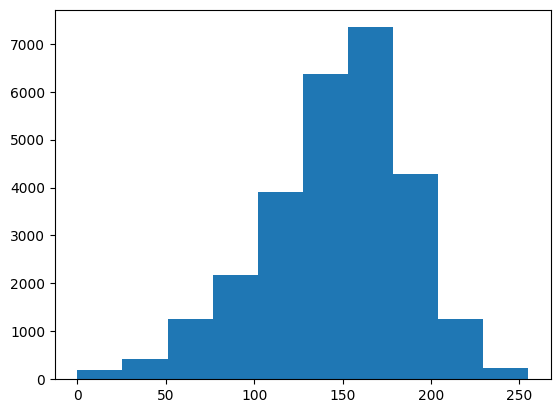

In [4]:
plt.hist(df.pixel1)

In [5]:
df.shape,dft.shape

((27455, 785), (7172, 785))

In [6]:
df.label.unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14], dtype=int64)

<AxesSubplot:xlabel='label', ylabel='count'>

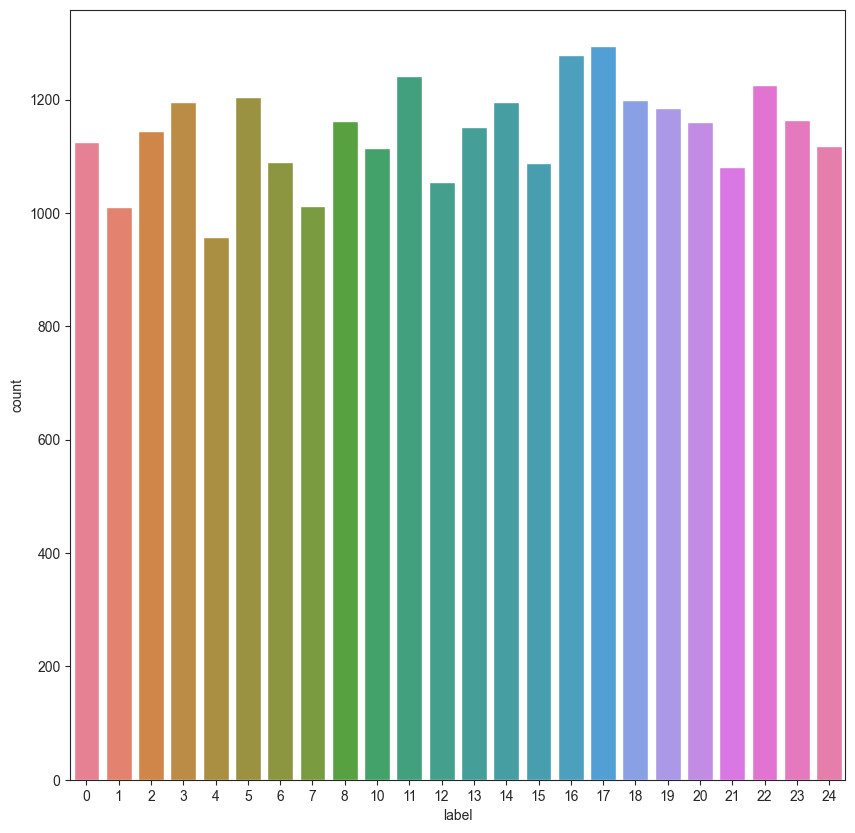

In [7]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("ticks")
sns.countplot(data=df,x="label",palette="husl")

In [8]:
y_train =df['label']
y_test =dft['label']
x_train=df.drop('label',axis=1)
x_test=dft.drop('label',axis=1)

In [9]:
x_train = x_train / 255 #scaling to values between 0 and 1
x_test = x_test / 255 

In [10]:
#one hot encoding all the values from 1 to 
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_test=lb.fit_transform(y_test)

In [11]:
y_test.shape,y_train.shape

((7172, 24), (27455, 24))

In [12]:
x_train.shape,x_test.shape

((27455, 784), (7172, 784))

In [13]:
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

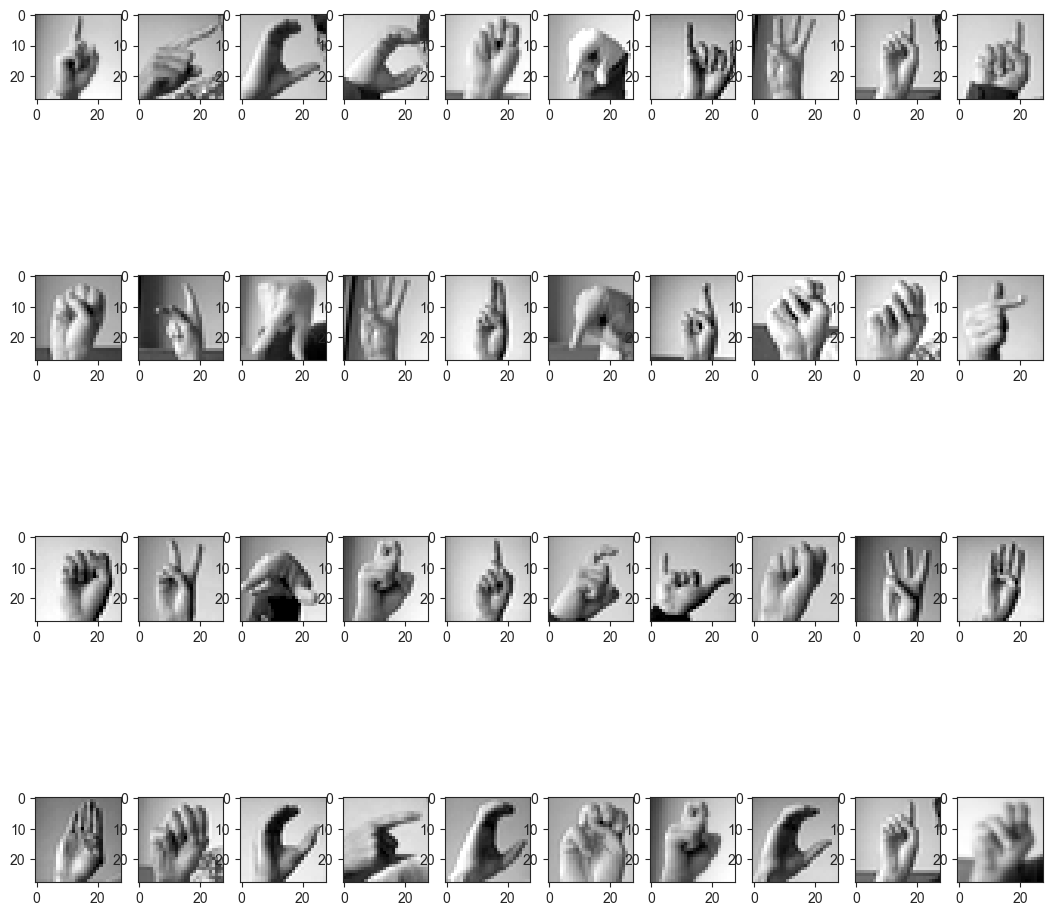

In [14]:
plt.figure(figsize=(13,13))
x, y = 10, 4 
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
plt.show()

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [17]:
model= Sequential()   
model.add(Conv2D(35,
                 kernel_size=(3,3),   ## kernel size nedir
                 activation='relu',
                 input_shape=(28,28,1),
                 strides = 1 ,
                 padding = 'same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),
                    strides = 2 , 
                    padding = 'same'))

model.add(Conv2D(50,
                 kernel_size=(3,3),
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),
                    strides=2,
                    padding='same'))
model.add(Flatten())
model.add(Dense(units=24,activation='softmax')) #change up for better results try
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])#sparse categorical crossentropy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 35)        350       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 35)       140       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 35)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        15800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

In [18]:
history= model.fit(datagen.flow(x_train,y_train,batch_size=128),epochs=10, validation_data=(x_test,y_test), callbacks=[learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 24s 105ms/step - loss: 1.1452 - accuracy: 0.6542 - val_loss: 2.8654 - val_accuracy: 0.1578 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 23s 105ms/step - loss: 0.3517 - accuracy: 0.8873 - val_loss: 1.2438 - val_accuracy: 0.6064 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 22s 105ms/step - loss: 0.1904 - accuracy: 0.9386 - val_loss: 0.2965 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 28s 128ms/step - loss: 0.1311 - accuracy: 0.9591 - val_loss: 0.1442 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 26s 121ms/step - loss: 0.0912 - accuracy: 0.9701 - val_loss: 0.0970 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 26s 119ms/step - loss: 0.0812 - accuracy: 0.9734 - val_loss: 0.0624 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 7/10
215/215 [==============================] 

In [19]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 8ms/step - loss: 0.0274 - accuracy: 0.9923
Accuracy of the model is -  99.23312664031982 %


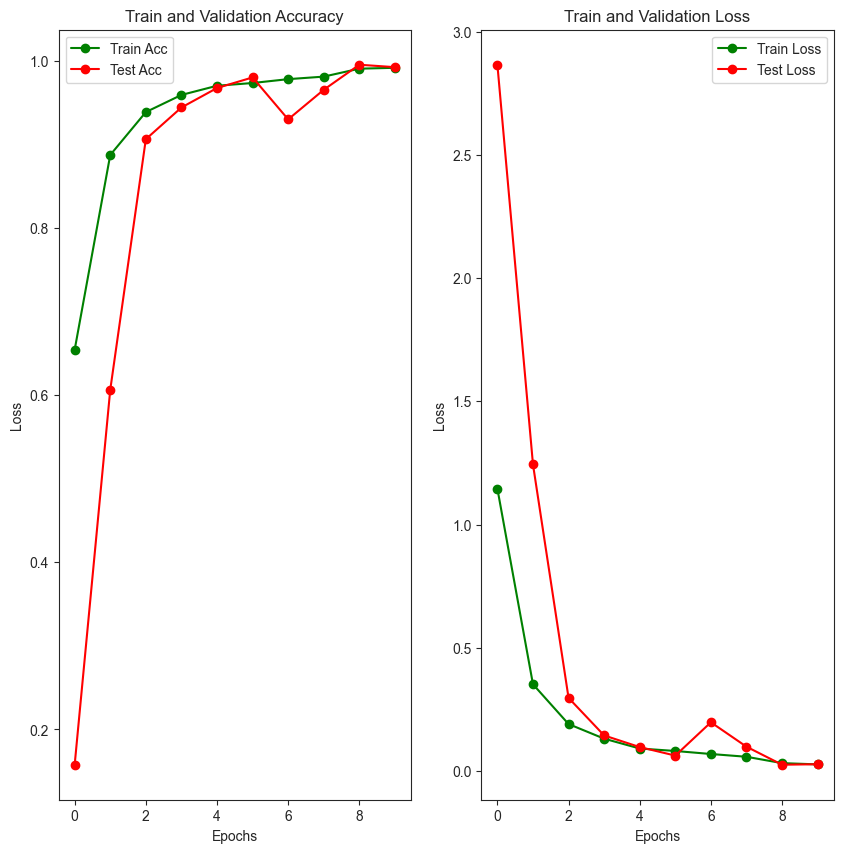

In [20]:
epochs = [i for i in range(10)]

fig,ax=plt.subplots(1,2)
train_acc= history.history['accuracy']
train_loss= history.history['loss']
val_acc= history.history['val_accuracy']
val_loss=history.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, val_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, train_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, val_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

In [29]:
D={0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'K',10:'L',11:'M',12:'N',13:'O',14:'P',15:'Q',16:'R',17:'S',18:'T',19:'U',20:'V',21:'W',22:'X',23:'Y'}

The predicted letter is V


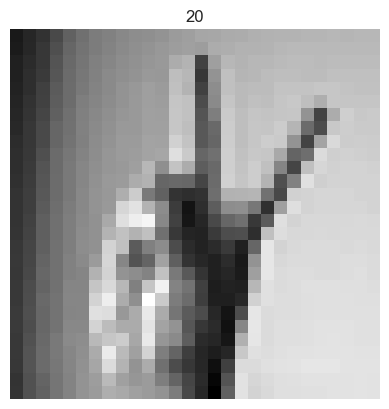

The predicted letter is V


In [30]:
i=56
plt.imshow(x_test[i].reshape(28,28),cmap='gray')
plt.title(np.where(y_test[i] == 1)[0][0])
plt.axis('off')
plt.show()
print("The predicted letter is",D[np.argmax(predictor[i],axis=0)])

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.
